# HUMAN-GOAL scenario

In [51]:
clear all
close all
clc

## 1 - Scenario definition

#### 1.1 - Add folders to search path

In [52]:
currentFolder = pwd;
currentFolder_splitted = string(strsplit(currentFolder, '/'));
projectFolder_index = find(strcmp(currentFolder_splitted, 'hrsi'));
env_path = strjoin(currentFolder_splitted(1, 1:projectFolder_index), '/');
addpath(genpath(env_path + '/utilities'))
addpath(genpath(env_path + '/classes'))

#### 1.2 - Artificial potential field parametes definition
In this case, we define just the attractive gain $K_a$.

In [53]:
Ka = 2;

#### 1.3 - Simulation parametes definition

In [54]:
DT = 0.1; % delta time
simulation_time = 150;
tout = 0 : DT : simulation_time;
dist_thres = 0.01; % distance threshold between moving agent and goal. 
                   % if distance < 0.01 then the goal has been reached

#### 1.4 - Simulation parametes definition [OPTIONAL]

In [55]:
N = {};

%% noise theta
Noise_theta = Noise(tout, "Noise_theta", 0, 0.03);
N{1,1} = Noise_theta;

%% noise D
Noise_D = Noise(tout, "Noise_D", 0, 0.001);
N{2,1} = Noise_D;

%% noise V
Noise_V = Noise(tout, "Noise_V", 0, 0.01);
N{3,1} = Noise_V;

#### 1.5 - Goals definition
goal position defined as static agent by creating an instance of Agent.
- param id: (integer) number associated to this agent
- param color: (char) color associated to this agent (example 'k', 'r')
- param Ka: (float) attractive gain
- param Kr: (float) repulsive gain
- param eta_0: (float) minimum distance from obstacles
- param x: (float) initial pos-x
- param y: (float) initial pos-y
- param theta: (float) initial orientation
- param tout: (array) time vector
- param rep_force_type: (enum) example REPULSIVE, VORTEX

In [56]:
G = {};
g1 = Agent(1, 'k', Ka, 0, 0, 1, 4, 0, tout, 0);
G{1,1} = g1;

g2 = Agent(2, 'k', Ka, 0, 0, -1, -4, 0, tout, 0);
G{2,1} = g2;

g3 = Agent(3, 'k', Ka, 0, 0, 9.4, 4.2, 0, tout, 0);
G{3,1} = g3;

#### 1.6 - Moving agent parameters definition

In [57]:
Kv = 0.2; % gain linear velocity
Kw = 3; % gain angular velocity
L = 1.25; % length orientation arrow (graph)
sat_op = true; % linear velocity saturation option
max_v = 1.75; % max linear velocity
task_op = true; % task option
max_t = 15; % max task duration [s]

#### 1.7 - Moving agent definition
human defined as moving agent by creating an instance of Unicycle.
  - param id: (integer) number associated to this agent
  - param color: (char) color associated to this agent (example 'k', 'r')
  - param Ka: (float) attractive gain
  - param Kr: (float) repulsive gain
  - param eta_0: (float) minimum distance from obstacles
  - param x: (float) initial pos-x
  - param y: (float) initial pos-y
  - param theta: (float) initial orientation
  - param tout: (array) time vector
  - param n_agent: (int) number of agent in the scenario
  - param L: (float) length orientation arrow
  - param sat_op: (bool) velocity saturation option
  - param max_v: (float) max velocity (active only if sat_op = True)
  - param task_op: (bool) task option
  - param Kv: (float) linear velocity gain
  - param Kw: (float) angular velocity gain
  
In this case, we define a unicycle with initial position $g_1$ and initial orientation $\theta = -\frac{pi}{2}$

In [58]:
n_agent = 4; % (3 static agent + 1 unicycle) 
U = {};
u1 = Unicycle(4, 'r', 0, 0, 0, g1.x(1), g1.y(1), -pi/2, tout, 0, n_agent, L, sat_op, max_v, task_op, Kv, Kw);
U{1,1} = u1;

set $g_1$ as goal for agent $u_1$ at $t = 1$

In [59]:
u1.set_goal(g1, 1)

## 2 - Data struct definition
Here, we define the data to retrieve from the simulation

In [60]:
data{1,1}.name = 'theta_g';
data{2,1}.name = 'd_g';
data{3,1}.name = 'v';

## 3 - System
Here, we define how the system evolves.

In [61]:
% time evolution
for t = 2 : length(tout)
    
    for i = 1 : length(U)
        % goal changing handling
        U{i}.g_changed(t) = ~U{i}.g_changed(t-1) && U{i}.d_a(t-1, U{i}.g_seq(t-1)) <= dist_thres;
        current_goal = U{i}.g_seq(t-1);
        if U{i}.g_changed(t)
            if current_goal + 1 <= length(G)
                current_goal = current_goal + 1;
            else
                current_goal = 1;
            end
            U{i}.task = t + randi(max_t/DT);
        end
        % set of the goal at each time step
        U{i}.set_goal(G{current_goal}, t);
        
        % new state for agent U{i}
        U{i}.compute_next_state(t, DT)
    end
    
    for i = 1 : length(U)
        % goal measurements (angle and distance)
        U{i}.bearing_g(t, Noise_theta.values(t))
        U{i}.range_g(t, Noise_D.values(t))

        % new velocity inputs (linear and angular)
        [Ft, gFt] = U{i}.total_force_field(t);
        U{i}.compute_next_inputs(t, Ft, gFt, Noise_V.values(t), 0)

    end

    % data handling
    data{1,1}.data(t,1) = wrapTo2Pi(U{1}.theta_a(t, U{1}.g_seq(t)));
    data{2,1}.data(t,1) = U{1}.d_a(t, U{1}.g_seq(t));
    data{3,1}.data(t,1) = abs(U{1}.v(t));
end

## 4 - Graphs generation

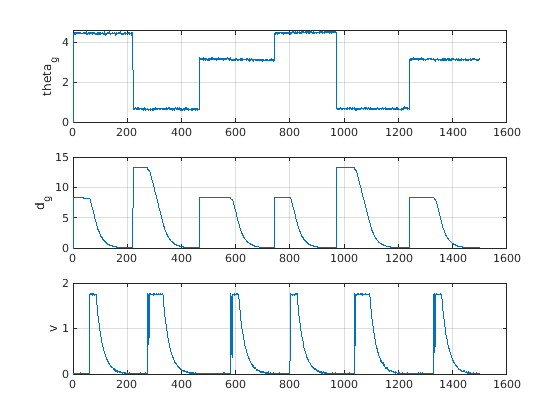

In [62]:
generate_graph(data)

## 5 - Save data
Create "data_folder" (if it does not exist) and save data.mat, data.csv and README.txt files

In [63]:
FileName = "data_folder";
        
if ~exist(FileName, 'dir')
    mkdir(FileName)
end
%% save .mat
save(FileName + '/data')
        
%% save .csv
save_csv(FileName, data);

%% README.txt creation
create_readme;

## 5 - Animation

#### 5.1 - Environment definition
axis and bundaries definition for animation

In [64]:
axis_def = [-10, 10, -10, 10];

ul = [-9.4 4.2];
ur = [9.4 4.2];
br = [9.4 -4.2];
bl = [-9.4 -4.2];

boundaries = [ul; ur; br; bl; ul];    

#### 5.2 - Plot animation

In [66]:
%step = 1; % change to speed up the video

%for t = 1 : step : length(tout)
%    plot_situation(false, 0, boundaries, [G;U], t, axis_def)
%end

![ChessUrl](https://raw.githubusercontent.com/lcastri/hrsi/master/img/human_goal_scenario.gif)